In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [2]:
elo_new = pd.read_csv('new_merchant_transactions.csv',parse_dates=['purchase_date'])
elo_hist = pd.read_csv('historical_transactions.csv',parse_dates=['purchase_date'])
def binarize(df):
    for col in ['authorized_flag','category_1']:
        df[col] = df[col].map({'Y':1,'N':0})
    return df
elo_new = binarize(elo_new)
elo_hist = binarize(elo_hist)

In [3]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018,2,1) - df['first_active_month'].dt.date).dt.days
    return df
elo_train = read_data('train.csv')
elo_test = read_data('test.csv')

In [5]:
import os
import json
from pandas.io.json import json_normalize
color = sns.color_palette()


from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [8]:
print("Training set shape: ",elo_train.shape)
print("Test set shape: ",elo_test.shape)

Training set shape:  (201917, 7)
Test set shape:  (123623, 6)


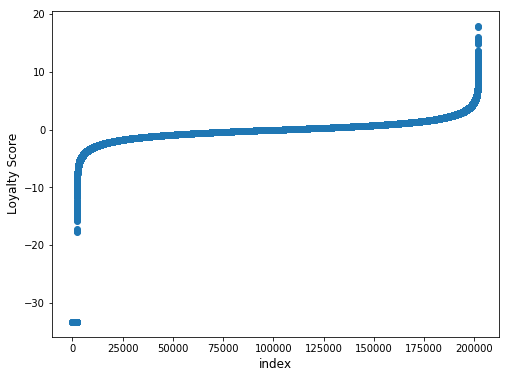

In [9]:
target_col = "target"

plt.figure(figsize=(8,6))
plt.scatter(range(elo_train.shape[0]), np.sort(elo_train[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()

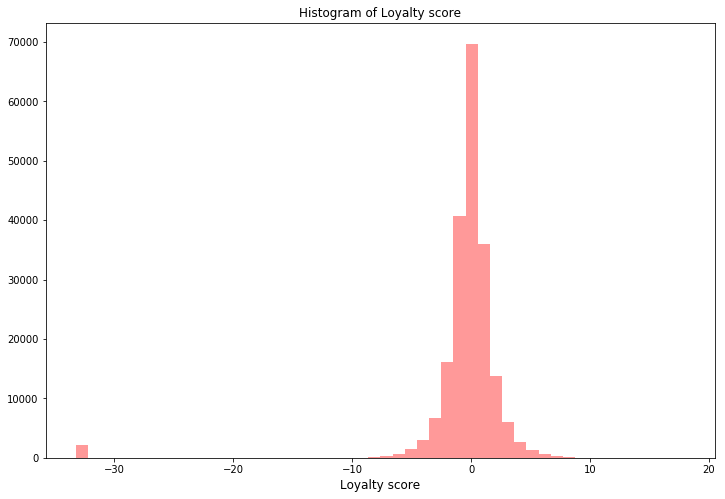

In [10]:
plt.figure(figsize=(12,8))
sns.distplot(elo_train[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

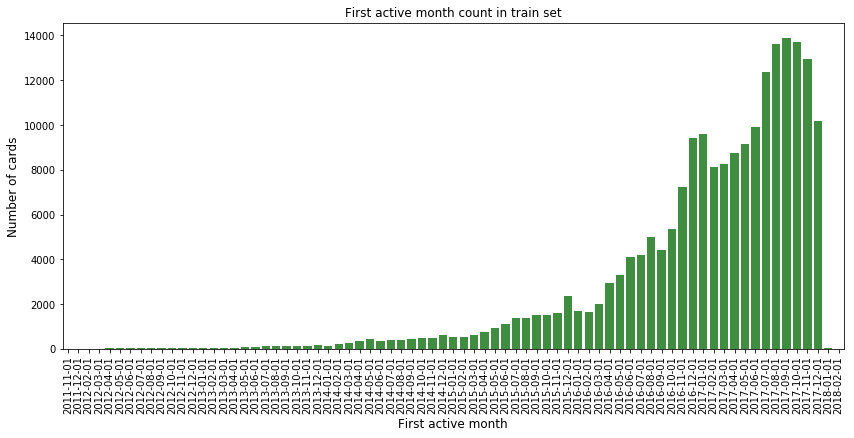

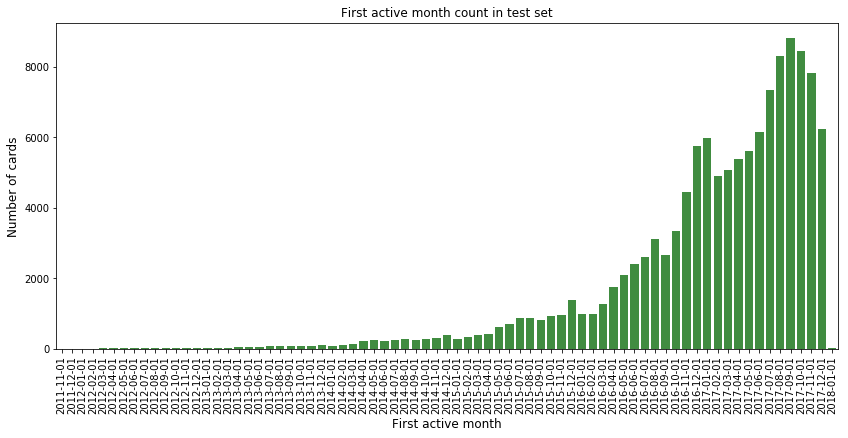

In [11]:
cnt_srs = elo_train['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

cnt_srs = elo_test['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in test set")
plt.show()

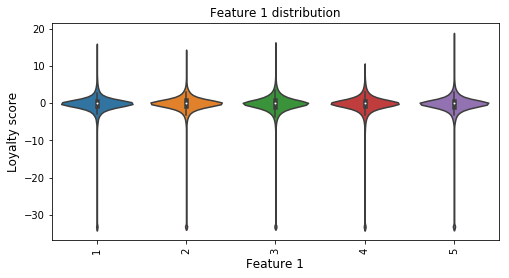

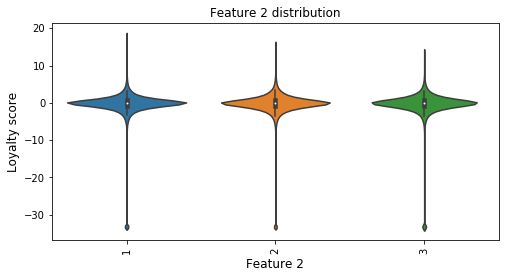

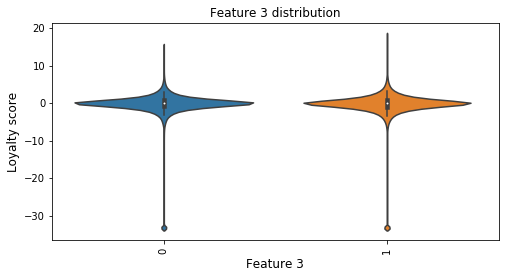

In [12]:
# feature 1
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_1", y=target_col, data=elo_train)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 1 distribution")
plt.show()

# feature 2
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_2", y=target_col, data=elo_train)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 2 distribution")
plt.show()

# feature 3
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_3", y=target_col, data=elo_train)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 3 distribution")
plt.show()

In [13]:
gdf = elo_hist.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_hist_transactions"]
eda_elo_train = pd.merge(elo_train, gdf, on="card_id", how="left")
eda_elo_test = pd.merge(elo_test, gdf, on="card_id", how="left")

In [14]:
cnt_srs = eda_elo_train.groupby("num_hist_transactions")[target_col].mean()
cnt_srs = cnt_srs.sort_index()
cnt_srs = cnt_srs[:-50]

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

trace = scatter_plot(cnt_srs, "orange")
layout = dict(
    title='Loyalty score by Number of historical transactions',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="Histtranscnt")

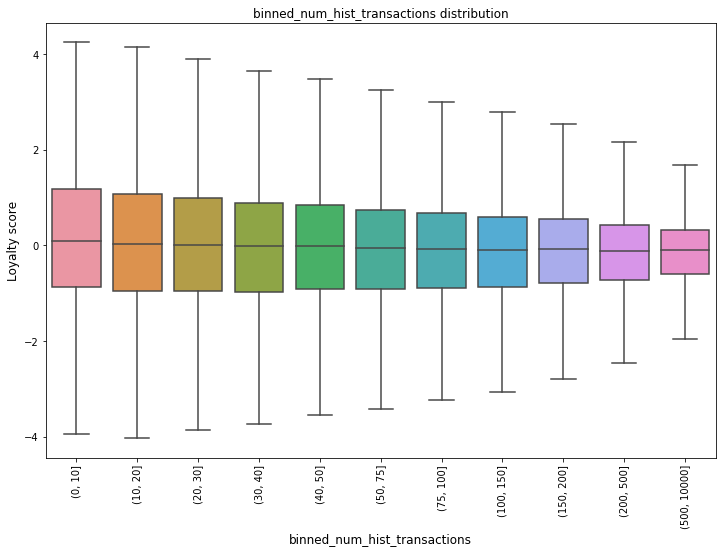

In [15]:
bins = [0, 10, 20, 30, 40, 50, 75, 100, 150, 200, 500, 10000]
eda_elo_train['binned_num_hist_transactions'] = pd.cut(eda_elo_train['num_hist_transactions'], bins)
cnt_srs = eda_elo_train.groupby("binned_num_hist_transactions")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_hist_transactions", y=target_col, data=eda_elo_train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_hist_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("binned_num_hist_transactions distribution")
plt.show()

In [16]:
gdf = elo_hist.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans"]
eda_elo_train = pd.merge(eda_elo_train, gdf, on="card_id", how="left")
eda_elo_test = pd.merge(eda_elo_test, gdf, on="card_id", how="left")

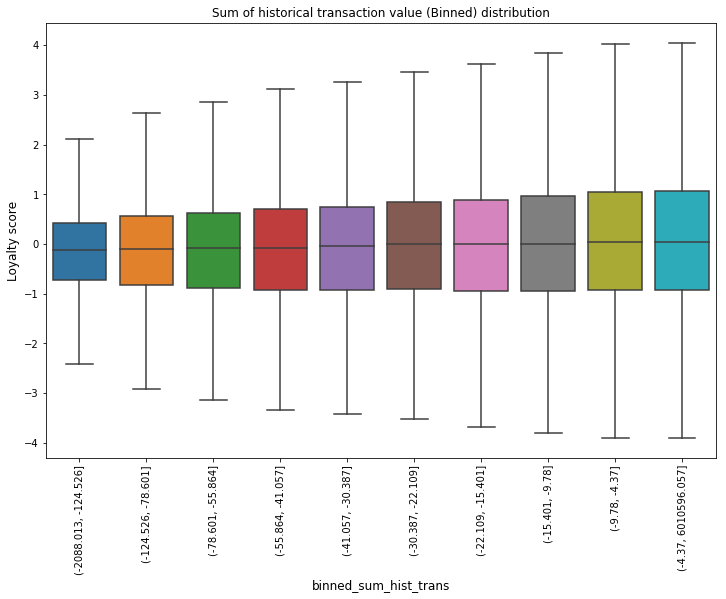

In [17]:
bins = np.percentile(eda_elo_train["sum_hist_trans"], range(0,101,10))
eda_elo_train['binned_sum_hist_trans'] = pd.cut(eda_elo_train['sum_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_hist_trans", y=target_col, data=eda_elo_train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_sum_hist_trans', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of historical transaction value (Binned) distribution")
plt.show()

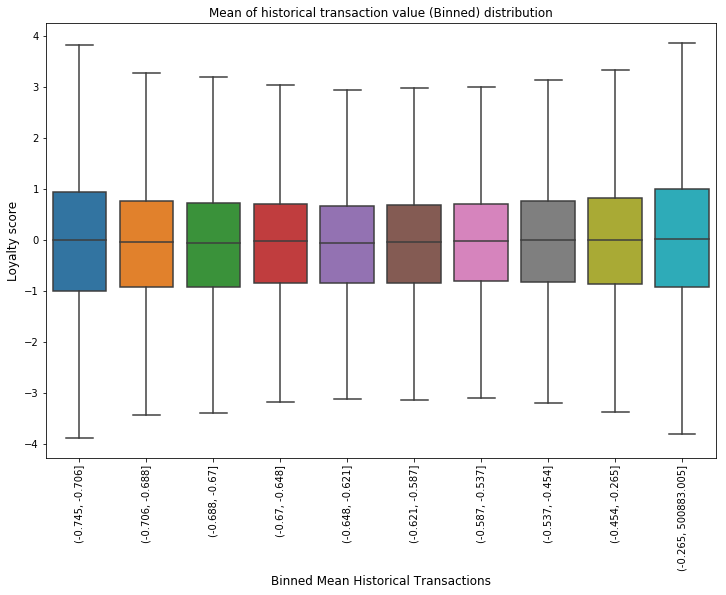

In [18]:
bins = np.percentile(eda_elo_train["mean_hist_trans"], range(0,101,10))
eda_elo_train['binned_mean_hist_trans'] = pd.cut(eda_elo_train['mean_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_mean_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_hist_trans", y=target_col, data=eda_elo_train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('Binned Mean Historical Transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of historical transaction value (Binned) distribution")
plt.show()

In [19]:
gdf = elo_new.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_merch_transactions"]
eda_elo_train = pd.merge(eda_elo_train, gdf, on="card_id", how="left")
eda_elo_test = pd.merge(eda_elo_test, gdf, on="card_id", how="left")

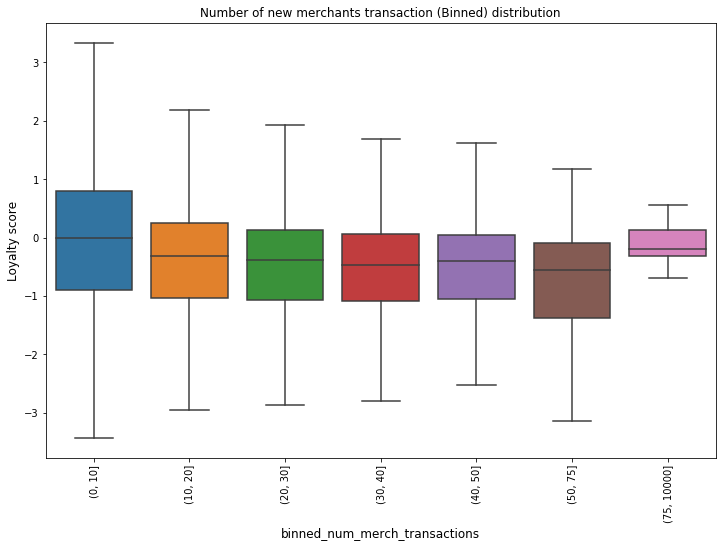

In [20]:
bins = [0, 10, 20, 30, 40, 50, 75, 10000]
eda_elo_train['binned_num_merch_transactions'] = pd.cut(eda_elo_train['num_merch_transactions'], bins)
cnt_srs = eda_elo_train.groupby("binned_num_merch_transactions")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_merch_transactions", y=target_col, data=eda_elo_train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_merch_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Number of new merchants transaction (Binned) distribution")
plt.show()

In [22]:
gdf = elo_new.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_merch_trans", "mean_merch_trans", "std_merch_trans", "min_merch_trans", "max_merch_trans"]
eda_elo_train = pd.merge(eda_elo_train, gdf, on="card_id", how="left")
eda_elo_test = pd.merge(eda_elo_test, gdf, on="card_id", how="left")

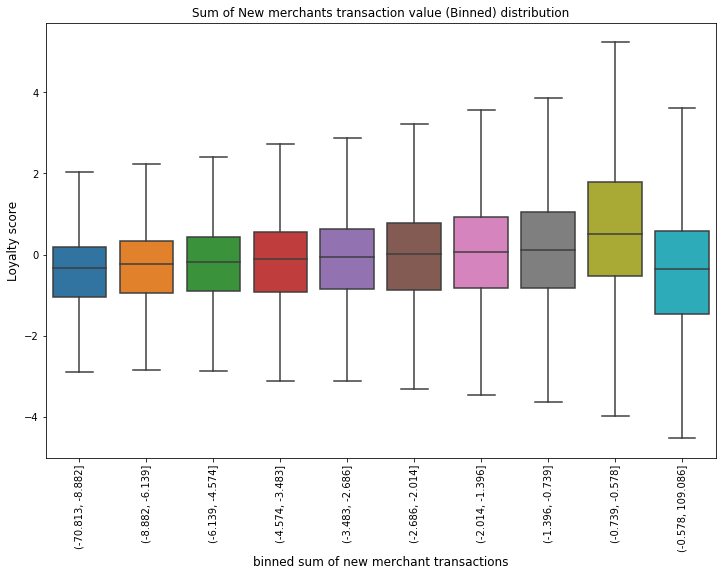

In [23]:
bins = np.nanpercentile(eda_elo_train["sum_merch_trans"], range(0,101,10))
eda_elo_train['binned_sum_merch_trans'] = pd.cut(eda_elo_train['sum_merch_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_merch_trans", y=target_col, data=eda_elo_train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned sum of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of New merchants transaction value (Binned) distribution")
plt.show()

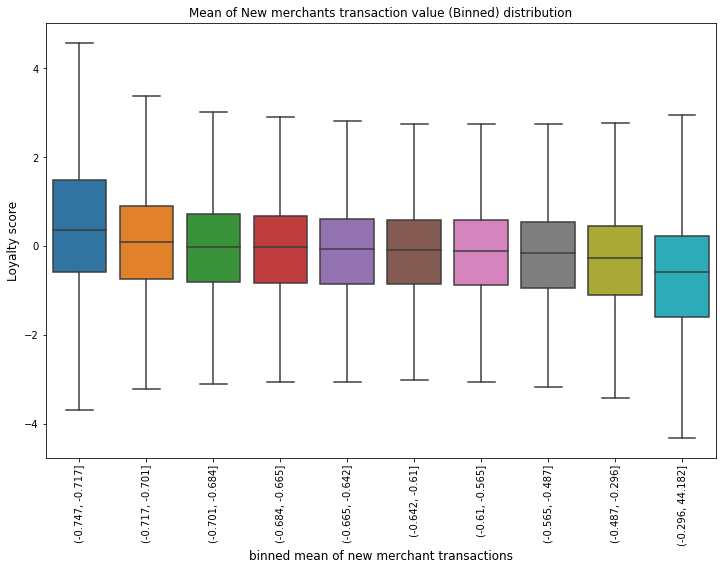

In [24]:
bins = np.nanpercentile(eda_elo_train["mean_merch_trans"], range(0,101,10))
eda_elo_train['binned_mean_merch_trans'] = pd.cut(eda_elo_train['mean_merch_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_merch_trans", y=target_col, data=eda_elo_train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned mean of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of New merchants transaction value (Binned) distribution")
plt.show()

In [25]:
elo_hist['month_diff'] = ((datetime.datetime.today() - elo_hist['purchase_date']).dt.days)//30
elo_hist['month_diff'] += elo_hist['month_lag']

elo_new['month_diff'] = ((datetime.datetime.today() - elo_new['purchase_date']).dt.days)//30
elo_new['month_diff'] += elo_new['month_lag']

In [26]:
elo_hist = pd.get_dummies(elo_hist,columns=['category_2','category_3'])
elo_new = pd.get_dummies(elo_new,columns=['category_2','category_3'])

agg_fun = {'authorized_flag':['mean']}
auth_mean = elo_hist.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

auth_trans = elo_hist[elo_hist['authorized_flag'] == 1]
hist_trans = elo_hist[elo_hist['authorized_flag'] == 0]

hist_trans['purchase_month'] = hist_trans['purchase_date'].dt.month
auth_trans['purchase_month'] = auth_trans['purchase_date'].dt.month
elo_new['purchase_month'] = elo_new['purchase_date'].dt.month

In [27]:
def aggregate_transactions(history):
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [28]:
history = aggregate_transactions(hist_trans)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



In [30]:
authorized = aggregate_transactions(auth_trans)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]

In [29]:
new = aggregate_transactions(elo_new)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]

In [31]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(auth_trans)

In [32]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [33]:
additional_fields = successive_aggregates(elo_new, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(elo_new, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(elo_new, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(elo_new, 'category_1', 'installments'),
                                            on = 'card_id', how='left')

In [34]:
hist_agg = elo_hist.groupby(['card_id'],as_index=False).agg({'authorized_flag':['mean','count'],'merchant_category_id':'count','installments':['max','mean']
                                                  ,'purchase_amount':'mean','purchase_date':['min','max']})
hist_agg.columns = ["_".join(x) for x in hist_agg.columns.ravel()]
hist_agg['purchase_date_min'] = pd.to_datetime(hist_agg['purchase_date_min'])
hist_agg['purchase_date_max'] = pd.to_datetime(hist_agg['purchase_date_max'])
hist_agg['spend_time_span'] = (hist_agg['purchase_date_max'] - hist_agg['purchase_date_min']).dt.days
hist_agg['spend_velocity'] = hist_agg['authorized_flag_count']/hist_agg['spend_time_span']

In [35]:
hist_agg.drop(['purchase_date_min','purchase_date_max','spend_time_span'],axis=1,inplace=True)

In [36]:
hist_agg.rename(columns={'card_id_':'card_id'},inplace=True)

In [37]:
elo_train_mrg = pd.merge(elo_train,hist_agg,left_on='card_id',right_on='card_id')

elo_test_mrg = pd.merge(elo_test,hist_agg,left_on='card_id',right_on='card_id')

In [38]:
hist_agg1 = elo_hist.groupby(['card_id','merchant_category_id'],as_index=False).agg({'merchant_id':'count'})

In [39]:
hist_cardid = elo_hist[['card_id']]
hist_cardid.drop_duplicates(inplace=True)

In [40]:
new_cardid = elo_new[['card_id']]
new_cardid.drop_duplicates(inplace=True)

In [41]:
cardid_merge = pd.merge(hist_cardid,new_cardid,how='left',indicator='new_trans_id')

In [42]:
elo_train_mrg = pd.merge(elo_train_mrg,cardid_merge,on='card_id',how='left',indicator='test_ind')

In [43]:
elo_test_mrg = pd.merge(elo_test_mrg,cardid_merge,on='card_id',how='left',indicator='test_ind')

In [44]:
elo_train_mrg.new_trans_id.replace(('left_only','both'),('No','Yes'),inplace=True)

elo_test_mrg.new_trans_id.replace(('left_only','both'),('No','Yes'),inplace=True)

In [45]:
elo_var6 = elo_hist.groupby(['card_id','city_id'],as_index=False).agg({'authorized_flag':'count'})

elo_var6.sort_values(by=['card_id','authorized_flag'],ascending=False,inplace=True)

elo_var6.drop_duplicates(subset='card_id',inplace=True)
elo_var6.sort_values(by=['card_id'],inplace=True)

In [46]:
elo_var6_new = elo_new.groupby(['card_id','city_id'],as_index=False).agg({'authorized_flag':'count'})

elo_var6_new.sort_values(by=['card_id','authorized_flag'],ascending=[True,False],inplace=True)

elo_var6_new.drop_duplicates(subset=['card_id'],inplace=True)

In [47]:
elo_var6_v = pd.merge(elo_var6,elo_var6_new,on=['card_id','city_id'],how='left',indicator='city_change_ind')
elo_var6_v.city_change_ind.replace(('left_only','both'),('No','Yes'),inplace=True)

In [48]:
elo_var7_hist = elo_hist.groupby(['card_id','merchant_category_id'],as_index=False).agg({'purchase_amount':'mean'})

In [49]:
elo_var7_new = elo_new.groupby(['card_id','merchant_category_id'],as_index=False).agg({'purchase_amount':'mean'})

In [50]:
elo_var7_mrg = pd.merge(elo_var7_hist,elo_var7_new,on=['card_id','merchant_category_id'],how='outer',indicator='Spnd_chg_ind',suffixes=['_hist','_new'])
elo_var7_mrg.sort_values(by=['card_id'],inplace=True)

In [51]:
elo_var7_mrg['spend_chg'] = elo_var7_mrg['purchase_amount_new']/elo_var7_mrg['purchase_amount_hist'] - 1
elo_var7_mrg[['spend_chg']] = elo_var7_mrg[['spend_chg']].fillna(value=0)
elo_var7_mrg.sort_values(by=['card_id','spend_chg'],ascending=[True,False],inplace=True)
elo_var7_mrg.drop_duplicates(subset=['card_id'],inplace=True)

In [52]:
elo_var3 = elo_hist.groupby(['card_id'],as_index=False).agg({'merchant_category_id':'nunique','city_id':'nunique'})
elo_var3.rename(columns={'merchant_category_id':'no_of_dist_merch','city_id':'no_of_dist_city'},inplace=True)

In [53]:
# Variable 1 - % of transactions with the most frequent merchant category
hist_agg2 = elo_hist.groupby(['card_id','merchant_category_id'],as_index=False).agg({'city_id':'count'})

hist_agg2.drop('merchant_category_id',axis=1,inplace=True)
hist_agg2.rename(columns={'city_id':'trans_count_merch'},inplace=True)

hist_agg2 = hist_agg2.sort_values('trans_count_merch',ascending=False).drop_duplicates('card_id')

hist_agg.rename(columns={'card_id_':'card_id'},inplace=True)

hist_agg = pd.merge(hist_agg,hist_agg2,on='card_id',how='left')

hist_agg['mer_cat_trans_per'] = hist_agg['trans_count_merch']/hist_agg['merchant_category_id_count']

In [54]:
elo_train_fin = pd.merge(elo_train, history, on='card_id', how='left')
elo_train_fin = pd.merge(elo_train_fin, authorized, on='card_id', how='left')
elo_train_fin = pd.merge(elo_train_fin, new, on='card_id', how='left')
elo_train_fin = pd.merge(elo_train_fin, final_group, on='card_id', how='left')
elo_train_fin = pd.merge(elo_train_fin, auth_mean, on='card_id', how='left')
elo_train_fin = pd.merge(elo_train_fin, additional_fields, on='card_id', how='left')
elo_train_fin = pd.merge(elo_train_fin,elo_train_mrg[['card_id','new_trans_id']],on='card_id',how='left')
elo_train_fin = pd.merge(elo_train_fin,elo_var6_v[['card_id','city_change_ind']],on='card_id',how='left')
elo_train_fin = pd.merge(elo_train_fin,elo_var7_mrg[['card_id','spend_chg']],on='card_id',how='left')
elo_train_fin = pd.merge(elo_train_fin,hist_agg[['card_id','mer_cat_trans_per']],on='card_id',how='left')
elo_train_fin = elo_train_fin.fillna(value=0)

In [55]:
elo_test_fin = pd.merge(elo_test, history, on='card_id', how='left')
elo_test_fin = pd.merge(elo_test_fin, authorized, on='card_id', how='left')
elo_test_fin = pd.merge(elo_test_fin, new, on='card_id', how='left')
elo_test_fin = pd.merge(elo_test_fin, final_group, on='card_id', how='left')
elo_test_fin = pd.merge(elo_test_fin, auth_mean, on='card_id', how='left')
elo_test_fin = pd.merge(elo_test_fin, additional_fields, on='card_id', how='left')
elo_test_fin = pd.merge(elo_test_fin,elo_test_mrg[['card_id','new_trans_id']],on='card_id',how='left')
elo_test_fin = pd.merge(elo_test_fin,elo_var6_v[['card_id','city_change_ind']],on='card_id',how='left')
elo_test_fin = pd.merge(elo_test_fin,elo_var7_mrg[['card_id','spend_chg']],on='card_id',how='left')
elo_test_fin = pd.merge(elo_test_fin,hist_agg[['card_id','mer_cat_trans_per']],on='card_id',how='left')
elo_test_fin = elo_test_fin.fillna(value=0)

In [56]:
elo_train.sort_values(by='card_id',inplace=True)
elo_train_fin.sort_values(by='card_id',inplace=True)
elo_test.sort_values(by='card_id',inplace=True)
elo_test_fin.sort_values(by='card_id',inplace=True)

In [57]:
elo_train_fin.drop(['card_id','first_active_month'],axis=1,inplace=True)
elo_test_fin.drop(['card_id','first_active_month'],axis=1,inplace=True)

In [58]:
elo_test_fin_v = pd.get_dummies(elo_test_fin)
elo_train_fin_v = pd.get_dummies(elo_train_fin)

In [59]:
labels = np.array(elo_train_fin_v['target'])

In [60]:
elo_train_fin_v = elo_train_fin_v.drop('target',axis=1)
feature_list = list(elo_train_fin_v.columns)
elo_train_fin_v = np.array(elo_train_fin_v)
elo_test_fin_v = np.array(elo_test_fin_v)

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(random_state=42)
xgb.fit(elo_train_fin_v,labels)
predictions2 = xgb.predict(elo_test_fin_v)
test_pred2 = pd.DataFrame(data={'card_id':np.array(elo_test['card_id']),'target':predictions2})

In [142]:
test_pred2.to_csv("submission_dec28.csv",index=False)

In [141]:
xgb_varimp = pd.DataFrame(data={'var_name':np.array(feature_list),'var_imp':xgb.feature_importances_})
xgb_varimp.sort_values(by='var_imp',ascending=False,inplace=True)
xgb_varimp

,var_imp,var_name
73,0.059767,auth_month_diff_mean
114,0.052478,new_purchase_amount_max
106,0.051020,new_month_lag_mean
81,0.048105,new_purchase_date_ptp
116,0.040816,new_purchase_amount_std
140,0.039359,purchase_amount_max_mean
83,0.034985,new_purchase_date_max
35,0.034985,hist_month_diff_mean
65,0.030612,auth_category_1_sum
103,0.030612,new_category_1_sum


In [143]:
test_pred2.shape

(123623, 2)